## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import train_utils
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

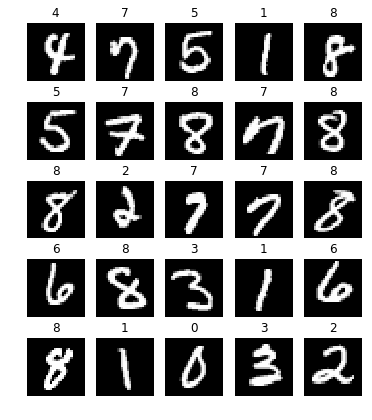

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)
def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [7]:
def reg_layer(inp,out,typ = 'None'):
    if typ =='None':
        mean=0
        std=0.01
    if typ =='Xav':
        mean = 0
        std = np.sqrt(2.0/(inp+out))
    if typ =='He':
        mean = 0
        std = np.sqrt(2.0/(inp))
    if typ =='He1':
        mean = 0
        std = np.sqrt(2.0/(out))    
    layer = nn.Linear(inp,out)
    init_layer(layer, mean, std)

    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    return layer

In [8]:
model = []

model.append(reg_layer(784,500))
model.append(nn.ReLU())

for i in range(10):
    model.append(reg_layer(500,500))
    model.append(nn.ReLU())
model.append(reg_layer(500,10))
model.append(nn.Softmax())
model_bad=nn.Sequential(*model) 

In [9]:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = model_bad(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model_bad.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0069571733474731
forward 0.1672322154045105
forward 0.02615596354007721
forward 0.0041366745717823505
forward 0.0006339167593978345
forward 9.895034600049257e-05
forward 1.5954374248394743e-05
forward 2.5233134692825843e-06
forward 3.8225689991122636e-07
forward 5.8921049372884227e-08
forward 8.918862093310054e-09
forward 1.3795317110876226e-09


C:\Users\ADMIN\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


backward 0.003399344626814127
backward 7.323112367885187e-05
backward 1.1809297575382516e-05
backward 1.7998972907662392e-06
backward 2.954606088678702e-07
backward 4.5281055349732924e-08
backward 6.983219780209993e-09
backward 1.086204015621206e-09
backward 1.7563013543497874e-10
backward 2.7279300346405577e-11
backward 4.430644219566293e-12
backward 7.055664646288262e-13


In [10]:
#Xavier
model = []
typ='He1'
model.append(reg_layer(784,500,typ))
model.append(nn.ReLU())

for i in range(10):
    model.append(reg_layer(500,500,typ))
    model.append(nn.ReLU())
model.append(reg_layer(500,10,typ))
model.append(nn.Softmax())
model_good=nn.Sequential(*model) 

In [11]:

n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = model_good(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model_good.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0069571733474731
forward 1.0443298816680908
forward 1.0882797241210938
forward 1.049757480621338
forward 1.060138463973999
forward 0.9968754649162292
forward 0.9667092561721802
forward 0.9748731255531311
forward 0.9513980150222778
forward 0.9992457032203674
forward 1.0394259691238403
forward 1.0059491395950317


C:\Users\ADMIN\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


backward 0.002539663342759013
backward 0.002486118581146002
backward 0.002559203887358308
backward 0.0025000290479511023
backward 0.002536904066801071
backward 0.0026376426685601473
backward 0.0024452100042253733
backward 0.002290370175614953
backward 0.0022032675333321095
backward 0.0022421374451369047
backward 0.002386055886745453
backward 0.0023649458307772875


### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [6]:
def train(network, train_loader, test_loader, epochs, learning_rate, ravel_init=False):        

    loss = nn.CrossEntropyLoss ()
    if torch.cuda.is_available():
        loss = loss.cuda()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []

            network.train()
            for X, y in train_loader:
                X = Variable(X)
                if ravel_init:
                    X = X.view(X.size(0), -1)
                y = Variable(y)
                if torch.cuda.is_available():
                    X = X.cuda()
                    y = y.cuda()

                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                loss_batch.backward()
                optimizer.step()
                
                losses.append(loss_batch.item())
                
                if torch.cuda.is_available():
                    accuracies.append((np.argmax(prediction.data.cpu().numpy(), 1)==y.data.cpu().numpy()).mean())
                else:
                    accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []  
            network.eval()
            for X, y in test_loader:
                X = Variable(X)
                if ravel_init:
                    X = X.view(X.size(0), -1)
                y = Variable(y)
                if torch.cuda.is_available():
                    X = X.cuda()
                    y = y.cuda()
                    
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                if torch.cuda.is_available():
                    accuracies.append((np.argmax(prediction.data.cpu().numpy(), 1)==y.data.cpu().numpy()).mean())
                else:
                    accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()
    

In [7]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=0, std=0.01), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        
        if self.training:
            mask = torch.bernoulli(torch.zeros(self.weight.size())+self.p)

        else:
            mask =torch.ones(self.weight.size())*self.p
        mask=Variable(mask,requires_grad=False)
        return torch.mm(x,self.weight*mask)+self.bias ##### YOUR CODE HERE #####


<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

Epoch 0... (Train/Test) NLL: 0.768/0.311	Accuracy: 0.745/0.905
Epoch 1... (Train/Test) NLL: 0.326/0.213	Accuracy: 0.901/0.934
Epoch 2... (Train/Test) NLL: 0.245/0.161	Accuracy: 0.925/0.952
Epoch 3... (Train/Test) NLL: 0.197/0.145	Accuracy: 0.941/0.955
Epoch 4... (Train/Test) NLL: 0.168/0.116	Accuracy: 0.949/0.964
Epoch 5... (Train/Test) NLL: 0.152/0.112	Accuracy: 0.953/0.967
Epoch 6... (Train/Test) NLL: 0.137/0.100	Accuracy: 0.959/0.969
Epoch 7... (Train/Test) NLL: 0.127/0.093	Accuracy: 0.962/0.971
Epoch 8... (Train/Test) NLL: 0.117/0.087	Accuracy: 0.964/0.974
Epoch 9... (Train/Test) NLL: 0.108/0.084	Accuracy: 0.966/0.975
Epoch 10... (Train/Test) NLL: 0.108/0.088	Accuracy: 0.967/0.974
Epoch 11... (Train/Test) NLL: 0.100/0.075	Accuracy: 0.968/0.978
Epoch 12... (Train/Test) NLL: 0.100/0.074	Accuracy: 0.969/0.978
Epoch 13... (Train/Test) NLL: 0.095/0.073	Accuracy: 0.970/0.979
Epoch 14... (Train/Test) NLL: 0.092/0.074	Accuracy: 0.971/0.978


C:\Users\ADMIN\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


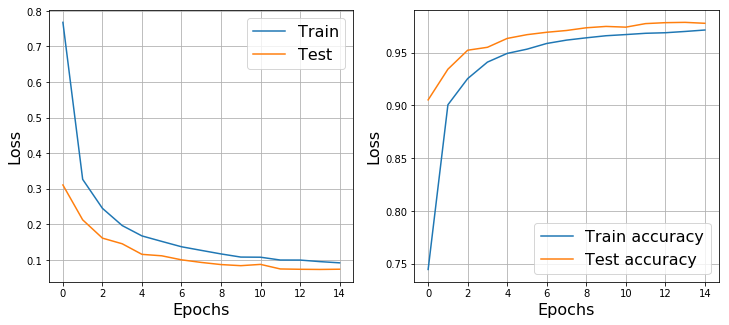

In [9]:

model1 = nn.Sequential(DropConnect(784,200,0.5),nn.ReLU(),
                  DropConnect(200,200,0.5),nn.ReLU(),
                   DropConnect(200,10,0.5))

train(network=model1,epochs=15,learning_rate=0.001,train_loader=train_loader,test_loader=test_loader,ravel_init=True)  

Epoch 0... (Train/Test) NLL: 0.268/0.126	Accuracy: 0.921/0.958
Epoch 1... (Train/Test) NLL: 0.102/0.094	Accuracy: 0.968/0.970
Epoch 2... (Train/Test) NLL: 0.070/0.081	Accuracy: 0.978/0.974
Epoch 3... (Train/Test) NLL: 0.053/0.076	Accuracy: 0.983/0.976
Epoch 4... (Train/Test) NLL: 0.041/0.074	Accuracy: 0.986/0.978
Epoch 5... (Train/Test) NLL: 0.034/0.072	Accuracy: 0.989/0.978
Epoch 6... (Train/Test) NLL: 0.028/0.081	Accuracy: 0.991/0.979
Epoch 7... (Train/Test) NLL: 0.023/0.094	Accuracy: 0.992/0.976
Epoch 8... (Train/Test) NLL: 0.023/0.077	Accuracy: 0.992/0.979
Epoch 9... (Train/Test) NLL: 0.018/0.091	Accuracy: 0.994/0.977
Epoch 10... (Train/Test) NLL: 0.019/0.095	Accuracy: 0.993/0.977
Epoch 11... (Train/Test) NLL: 0.015/0.101	Accuracy: 0.995/0.976
Epoch 12... (Train/Test) NLL: 0.014/0.086	Accuracy: 0.995/0.979
Epoch 13... (Train/Test) NLL: 0.014/0.093	Accuracy: 0.995/0.978
Epoch 14... (Train/Test) NLL: 0.011/0.091	Accuracy: 0.996/0.981


C:\Users\ADMIN\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


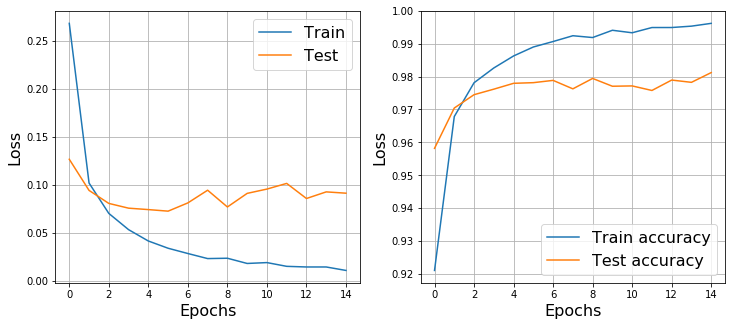

In [10]:
model2 = nn.Sequential(nn.Linear(784,200),nn.ReLU(),
                   nn.Linear(200,200),nn.ReLU(),
                   nn.Linear(200,10))

train(model2,epochs=15,learning_rate=0.001,test_loader=test_loader,train_loader=train_loader,ravel_init=True) 

Epoch 0... (Train/Test) NLL: 0.457/0.166	Accuracy: 0.857/0.948
Epoch 1... (Train/Test) NLL: 0.236/0.116	Accuracy: 0.930/0.964
Epoch 2... (Train/Test) NLL: 0.200/0.103	Accuracy: 0.940/0.969
Epoch 3... (Train/Test) NLL: 0.178/0.098	Accuracy: 0.946/0.970
Epoch 4... (Train/Test) NLL: 0.158/0.093	Accuracy: 0.952/0.973
Epoch 5... (Train/Test) NLL: 0.149/0.096	Accuracy: 0.955/0.969
Epoch 6... (Train/Test) NLL: 0.142/0.087	Accuracy: 0.957/0.974
Epoch 7... (Train/Test) NLL: 0.133/0.079	Accuracy: 0.960/0.976
Epoch 8... (Train/Test) NLL: 0.130/0.081	Accuracy: 0.960/0.976
Epoch 9... (Train/Test) NLL: 0.127/0.075	Accuracy: 0.962/0.977
Epoch 10... (Train/Test) NLL: 0.121/0.078	Accuracy: 0.964/0.976
Epoch 11... (Train/Test) NLL: 0.121/0.079	Accuracy: 0.963/0.976
Epoch 12... (Train/Test) NLL: 0.115/0.079	Accuracy: 0.966/0.977
Epoch 13... (Train/Test) NLL: 0.114/0.079	Accuracy: 0.965/0.978
Epoch 14... (Train/Test) NLL: 0.108/0.071	Accuracy: 0.967/0.979


C:\Users\ADMIN\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


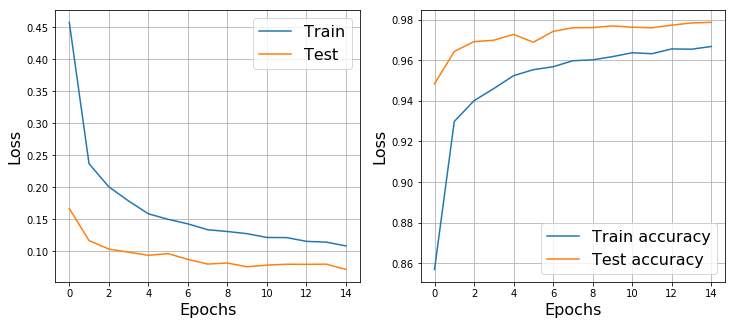

In [12]:
model3 = nn.Sequential(nn.Linear(784, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10))

train(model3, train_loader, test_loader, 15, 0.001, ravel_init=True)

<i> 2.3 Сделайте выводы по третьей части </i>

З DropOut не переобучается на трейне.

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [13]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, input_dim):
        super(LayerNormalization, self).__init__()
        self.gamma = nn.Parameter(torch.FloatTensor(input_dim).fill_(1.0), requires_grad=True)
        self.delta = nn.Parameter(torch.FloatTensor(input_dim).fill_(0.01), requires_grad=True)
        
    def forward(self, x):
        output = self.gamma * (x - torch.mean(x, 1, True)) / torch.std(x, 1, True).view(x.size()[0],-1) + self.delta
        return output

Epoch 0... (Train/Test) NLL: 0.230/0.124	Accuracy: 0.935/0.963
Epoch 1... (Train/Test) NLL: 0.088/0.094	Accuracy: 0.973/0.969
Epoch 2... (Train/Test) NLL: 0.064/0.086	Accuracy: 0.981/0.973
Epoch 3... (Train/Test) NLL: 0.051/0.078	Accuracy: 0.984/0.976
Epoch 4... (Train/Test) NLL: 0.039/0.075	Accuracy: 0.987/0.976
Epoch 5... (Train/Test) NLL: 0.033/0.079	Accuracy: 0.989/0.976
Epoch 6... (Train/Test) NLL: 0.027/0.065	Accuracy: 0.991/0.980
Epoch 7... (Train/Test) NLL: 0.023/0.071	Accuracy: 0.992/0.977
Epoch 8... (Train/Test) NLL: 0.019/0.072	Accuracy: 0.994/0.979
Epoch 9... (Train/Test) NLL: 0.019/0.073	Accuracy: 0.994/0.980
Epoch 10... (Train/Test) NLL: 0.016/0.078	Accuracy: 0.995/0.980
Epoch 11... (Train/Test) NLL: 0.018/0.074	Accuracy: 0.993/0.980
Epoch 12... (Train/Test) NLL: 0.011/0.077	Accuracy: 0.996/0.980
Epoch 13... (Train/Test) NLL: 0.014/0.072	Accuracy: 0.995/0.982
Epoch 14... (Train/Test) NLL: 0.011/0.083	Accuracy: 0.996/0.979


C:\Users\ADMIN\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


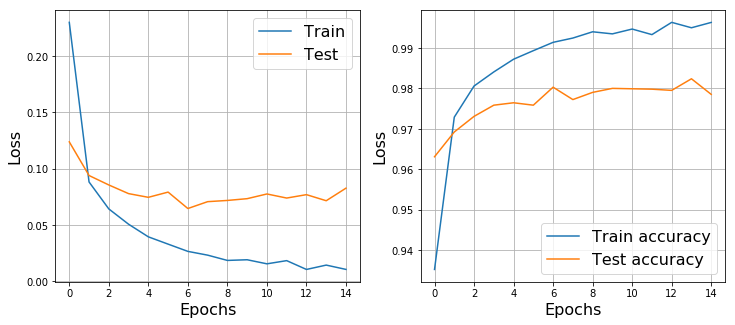

In [14]:
model4 = nn.Sequential(nn.Linear(784, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 10))

train(model4, train_loader, test_loader, 15, 0.001, ravel_init=True)

Epoch 0... (Train/Test) NLL: 0.271/0.102	Accuracy: 0.933/0.969
Epoch 1... (Train/Test) NLL: 0.082/0.077	Accuracy: 0.975/0.975
Epoch 2... (Train/Test) NLL: 0.053/0.071	Accuracy: 0.984/0.979
Epoch 3... (Train/Test) NLL: 0.037/0.068	Accuracy: 0.988/0.977
Epoch 4... (Train/Test) NLL: 0.029/0.070	Accuracy: 0.991/0.978
Epoch 5... (Train/Test) NLL: 0.022/0.070	Accuracy: 0.993/0.979
Epoch 6... (Train/Test) NLL: 0.018/0.063	Accuracy: 0.994/0.981
Epoch 7... (Train/Test) NLL: 0.016/0.068	Accuracy: 0.995/0.980
Epoch 8... (Train/Test) NLL: 0.017/0.074	Accuracy: 0.994/0.980
Epoch 9... (Train/Test) NLL: 0.013/0.068	Accuracy: 0.995/0.983
Epoch 10... (Train/Test) NLL: 0.012/0.072	Accuracy: 0.996/0.981
Epoch 11... (Train/Test) NLL: 0.011/0.074	Accuracy: 0.996/0.981
Epoch 12... (Train/Test) NLL: 0.011/0.063	Accuracy: 0.996/0.983
Epoch 13... (Train/Test) NLL: 0.009/0.074	Accuracy: 0.997/0.981
Epoch 14... (Train/Test) NLL: 0.010/0.070	Accuracy: 0.997/0.981


C:\Users\ADMIN\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


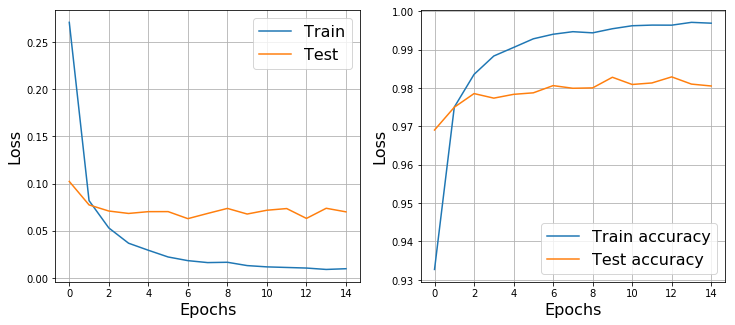

In [22]:
model4 = nn.Sequential(nn.Linear(784, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 10))

train(model4, train_loader, test_loader, 15, 0.001, ravel_init=True)

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

С батч нормализацией faster learning.

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: